# Import libraries

In [91]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import datetime

%matplotlib inline
sns.set()

In [92]:
import time
from  sklearn.metrics import mean_squared_error
start_time = time.time()
from math import *
import lightgbm as lgb



# Read dataset from work directory

In [93]:
sales_train = pd.read_csv('sales_train.csv.gz')
sales_test = pd.read_csv('test.csv.gz')
shops = pd.read_csv('shops.csv')
items = pd.read_csv('items.csv')
item_cats = pd.read_csv('item_categories.csv')
sampleSubmission = pd.read_csv('sample_submission.csv.gz')

sales_train.name = 'sales_train'
sales_test.name = 'sales_test'
shops.name = 'shops'
items.name = 'items'
item_cats.name = 'item_cats'

In [94]:
dflist = [sales_train, sales_test, shops, items, item_cats]
#show_info(dflist)
print('training set: ', sales_train.shape)
print('test set: ', sales_test.shape)
print('num of shops: ', shops.shape)
print('num of items: ',items.shape)
print('num of item categories: ',item_cats.shape)

training set:  (2935849, 6)
test set:  (214200, 3)
num of shops:  (60, 2)
num of items:  (22170, 3)
num of item categories:  (84, 2)


# building dummy features for test dataset-34th month

In [95]:
sales_test['ID'] = sales_test.index
sales_train['ID'] = sales_train.index
sales_test['set'] = 'test'
sales_train['set'] = 'train'
sales_test['date_block_num'] = 34
sales_test['item_price'] = np.nan
sales_test['item_cnt_day'] = np.nan
sales_test['date'] = '30.11.2015'

In [96]:
sales_test.head(3)

,ID,shop_id,item_id,set,date_block_num,item_price,item_cnt_day,date
0,0,5,5037,test,34,NaN,NaN,30.11.2015
1,1,5,5320,test,34,NaN,NaN,30.11.2015
2,2,5,5233,test,34,NaN,NaN,30.11.2015


In [97]:
sales_train = sales_train[['ID', 'set', 'date', 'date_block_num', 'shop_id', 'item_id', 'item_price', 'item_cnt_day']]
sales_test = sales_test[['ID', 'set', 'date', 'date_block_num', 'shop_id', 'item_id', 'item_price', 'item_cnt_day']]

In [98]:
sales_test.head(3)

,ID,set,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,0,test,30.11.2015,34,5,5037,NaN,NaN
1,1,test,30.11.2015,34,5,5320,NaN,NaN
2,2,test,30.11.2015,34,5,5233,NaN,NaN


In [99]:
data = sales_train.append(sales_test)

# merge shops,items and item_cat

In [100]:
data = data.merge(shops, how = 'left', on = 'shop_id')
data = data.merge(items, how = 'left', on = 'item_id')
data = data.merge(item_cats, how = 'left', on = 'item_category_id')

In [101]:
data.head(3)

,ID,set,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_name,item_category_id,item_category_name
0,0,train,02.01.2013,0,59,22154,999.0,1.0,"Ярославль ТЦ ""Альтаир""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
1,1,train,03.01.2013,0,25,2552,899.0,1.0,"Москва ТРК ""Атриум""",DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил
2,2,train,05.01.2013,0,25,2552,899.0,-1.0,"Москва ТРК ""Атриум""",DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил


# extract time features

In [102]:
data['date'] = pd.to_datetime(data['date'], format='%d.%m.%Y')
data['month'] = data['date'].dt.month
data['year'] = data['date'].dt.year
data['day'] = data['date'].dt.day
data['weekday'] = data['date'].dt.weekday

In [103]:
data.head()

,ID,set,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_name,item_category_id,item_category_name,month,year,day,weekday
0,0,train,2013-01-02,0,59,22154,999.00,1.0,"Ярославль ТЦ ""Альтаир""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,1,2013,2,2
1,1,train,2013-01-03,0,25,2552,899.00,1.0,"Москва ТРК ""Атриум""",DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил,1,2013,3,3
2,2,train,2013-01-05,0,25,2552,899.00,-1.0,"Москва ТРК ""Атриум""",DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил,1,2013,5,5
3,3,train,2013-01-06,0,25,2554,1709.05,1.0,"Москва ТРК ""Атриум""",DEEP PURPLE Who Do You Think We Are LP,58,Музыка - Винил,1,2013,6,6
4,4,train,2013-01-15,0,25,2555,1099.00,1.0,"Москва ТРК ""Атриум""",DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,Музыка - CD фирменного производства,1,2013,15,1


In [104]:
data.to_csv('newsampple', header=True, index=False, encoding='utf-8')

# highly skewed target data

C:\Users\santh_000\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


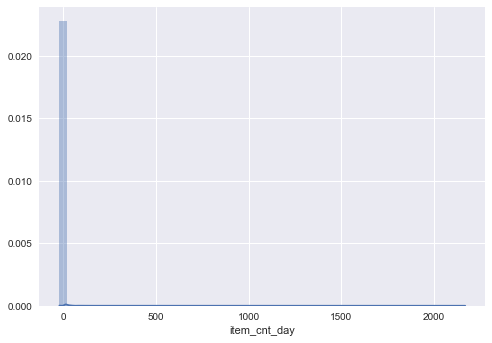

In [105]:
cnt_Data = data[(data.set == 'train')]['item_cnt_day']
sns.distplot(cnt_Data)

In [106]:
data['item_cnt_day_dup'] = data['item_cnt_day'] # keep for record
data['item_cnt_day'] = data['item_cnt_day_dup'].clip(0, 20)#clip target 20 id

In [107]:
data['item_price'].describe()

count    2.935849e+06
mean     8.908532e+02
std      1.729800e+03
min     -1.000000e+00
25%      2.490000e+02
50%      3.990000e+02
75%      9.990000e+02
max      3.079800e+05
Name: item_price, dtype: float64

# Removing data outlier

In [108]:
data[data['item_price'] == -1]

,ID,set,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_name,item_category_id,item_category_name,month,year,day,weekday,item_cnt_day_dup
484683,484683,train,2013-05-15,4,32,2973,-1.0,1.0,"Москва ТЦ ""Серебряный Дом""","DmC Devil May Cry [PS3, русские субтитры]",19,Игры - PS3,5,2013,15,2,1.0


In [109]:
meanPrice = data[data.item_id == 2973]['item_price'].mean()
data.loc[data.index == 484683, 'item_price'] = meanPrice


In [110]:
data[data.item_price > np.nanpercentile(data.item_price, 99.9)].groupby(['item_id'])['item_price'].agg(["mean", "max", "min", "std", "count"])

,mean,max,min,std,count
item_id,,,,,
102,27900.000000,27900.0,27900.00,0.000000,2
475,29200.000000,35300.0,25500.00,3925.332507,18
476,28050.000000,30600.0,25500.00,2944.486373,4
2410,34713.500000,36990.0,32437.00,3219.457175,2
3142,28474.500000,30705.0,26244.00,3154.403351,2
3143,29700.000000,29700.0,29700.00,NaN,1
5748,35132.857143,36990.0,32990.00,2035.400978,7
5909,28990.000000,28990.0,28990.00,NaN,1
5960,29999.000000,29999.0,29999.00,NaN,1


In [111]:
data[data.item_id == 6066]

,ID,set,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_name,item_category_id,item_category_name,month,year,day,weekday,item_cnt_day_dup
1163158,1163158,train,2013-12-13,11,12,6066,307980.0,1.0,Интернет-магазин ЧС,Radmin 3 - 522 лиц.,75,Программы - Для дома и офиса,12,2013,13,4,1.0


In [112]:
data = data.drop([1163158], axis= 0)

# create features

In [113]:
data['revenue'] = data['item_cnt_day'] * data['item_price']

In [114]:
data['date'] = pd.to_datetime(data['date'], format='%d.%m.%Y')

In [115]:
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month

In [116]:
data.head(3)

,ID,set,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_name,item_category_id,item_category_name,month,year,day,weekday,item_cnt_day_dup,revenue
0,0,train,2013-01-02,0,59,22154,999.0,1.0,"Ярославль ТЦ ""Альтаир""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,1,2013,2,2,1.0,999.0
1,1,train,2013-01-03,0,25,2552,899.0,1.0,"Москва ТРК ""Атриум""",DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил,1,2013,3,3,1.0,899.0
2,2,train,2013-01-05,0,25,2552,899.0,0.0,"Москва ТРК ""Атриум""",DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил,1,2013,5,5,-1.0,0.0


In [117]:
data.to_csv('newsam.csv', header=True, index=False, encoding='utf-8')

# Month Vs Revenue comparison

In [118]:
plt.rcParams['figure.figsize'] = (15, 12)

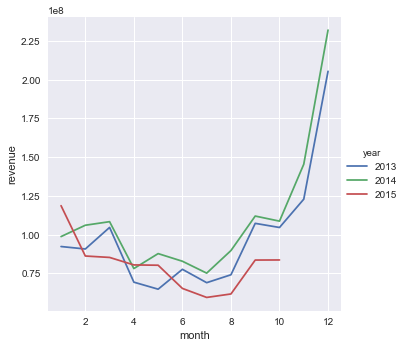

In [119]:
monthlyRev = pd.DataFrame(data.groupby(["month", "year"], as_index=False)["revenue"].sum())
monthlyRev.head()


g = sns.FacetGrid(data = monthlyRev.sort_values(by="month"), hue = "year", size = 5, legend_out=True)
g = g.map(plt.plot, "month", "revenue")
g.add_legend()

In [120]:
# change data type 
def cast_dtype(df, cols, dtype):
    df[cols] = df[cols].astype(dtype)
    
    return df

In [121]:
def downcast_dtypes(df):

    # Select columns to downcast to reduce memory
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast to 32 bits
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    
    return df

# Month Vs Revenue comparison

In [122]:
vizdata = data.groupby(['year','month'])['revenue'].sum()
vizdata = pd.DataFrame(vizdata)
vizdata.reset_index(inplace=True)
cast_dtype(vizdata, ['year','month'], object);

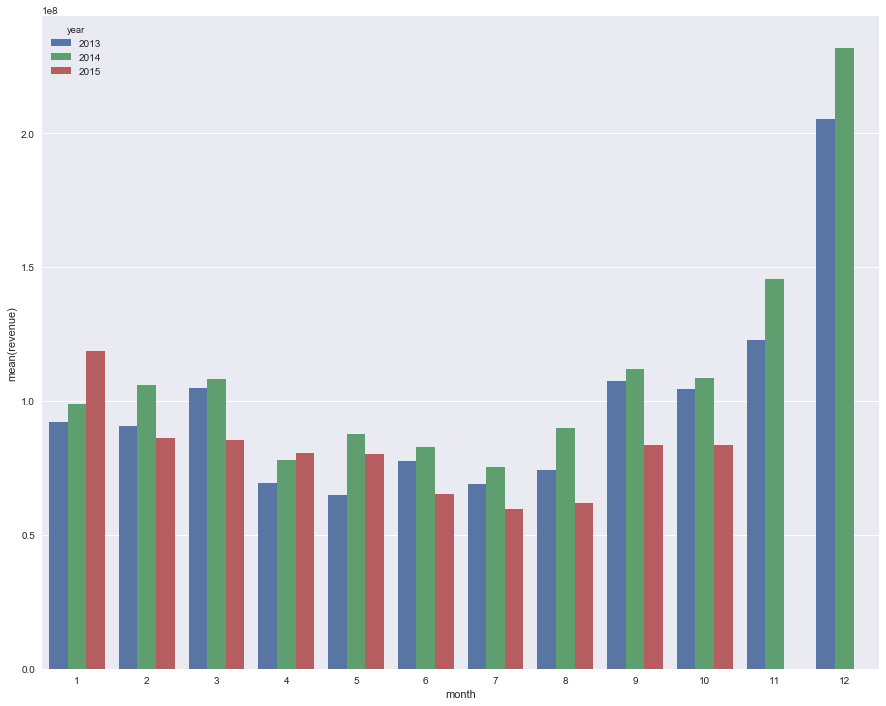

In [123]:
sns.barplot(x='month', y='revenue', hue='year', data=vizdata)

# Week vs revenue

In [124]:
vizdata = data.groupby(['weekday'])['revenue'].sum()
vizdata = pd.DataFrame(vizdata)
vizdata.reset_index(inplace=True)

In [125]:
plt.rcParams['figure.figsize']=(10,10)

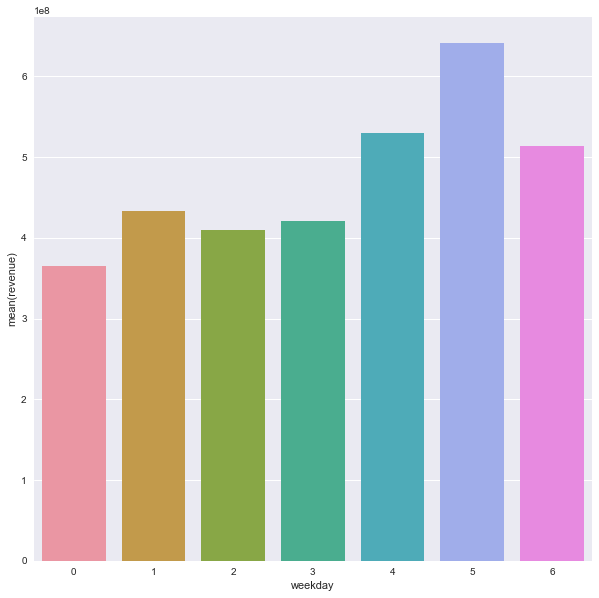

In [126]:
sns.barplot(x='weekday', y='revenue', data=vizdata)


# item category vs revenue

In [127]:
vizdata = data.groupby(['item_category_id'])['revenue'].sum()
vizdata = pd.DataFrame(vizdata)
vizdata.reset_index(inplace=True)
vizdata.nlargest(5, 'revenue').merge(item_cats, how = 'left', on = 'item_category_id')

,item_category_id,revenue,item_category_name
0,19,4.027723e+08,Игры - PS3
1,20,3.533649e+08,Игры - PS4
2,12,2.749915e+08,Игровые консоли - PS4
3,23,2.578328e+08,Игры - XBOX 360
4,30,2.464179e+08,Игры PC - Стандартные издания


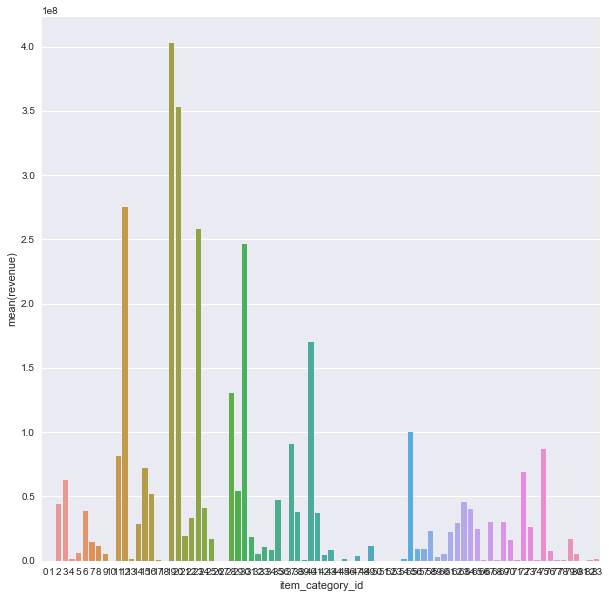

In [128]:
plot = sns.barplot(x='item_category_id', y='revenue', data=vizdata)

# plot shop vs revenue

In [129]:
vizdata = data.groupby(['shop_id'])['revenue'].sum()
vizdata = pd.DataFrame(vizdata)
vizdata.reset_index(inplace=True)
vizdata.nlargest(5, 'revenue').merge(shops, how = 'left', on = 'shop_id')

,shop_id,revenue,shop_name
0,31,2.285372e+08,"Москва ТЦ ""Семеновский"""
1,25,2.087222e+08,"Москва ТРК ""Атриум"""
2,28,1.587645e+08,"Москва ТЦ ""МЕГА Теплый Стан"" II"
3,42,1.431199e+08,"СПб ТК ""Невский Центр"""
4,54,1.407470e+08,"Химки ТЦ ""Мега"""


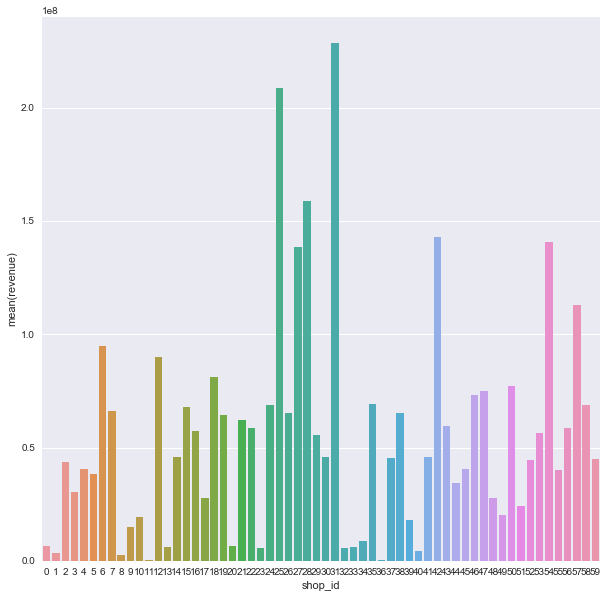

In [130]:
plot = sns.barplot(x='shop_id', y='revenue', data=vizdata)

In [131]:
data = downcast_dtypes(data)

In [132]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3150048 entries, 0 to 3150048
Data columns (total 18 columns):
ID                    int32
set                   object
date                  datetime64[ns]
date_block_num        int32
shop_id               int32
item_id               int32
item_price            float32
item_cnt_day          float32
shop_name             object
item_name             object
item_category_id      int32
item_category_name    object
month                 int32
year                  int32
day                   int32
weekday               int32
item_cnt_day_dup      float32
revenue               float32
dtypes: datetime64[ns](1), float32(4), int32(9), object(4)
memory usage: 300.4+ MB


In [133]:
index_cols = ['shop_id', 'item_id', 'date_block_num']

In [134]:
from itertools import product #This tool computes the cartesian product of input iterables
casc = [] 
for block_num in data['date_block_num'].unique():
    cur_shops = data.loc[data['date_block_num'] == block_num, 'shop_id'].unique()
    cur_items = data.loc[data['date_block_num'] == block_num, 'item_id'].unique()
    casc.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))

In [135]:
casc = pd.DataFrame(np.vstack(casc), columns = index_cols, dtype=np.int32)

In [136]:
casc.head(10)

,shop_id,item_id,date_block_num
0,59,22154,0
1,59,2552,0
2,59,2554,0
3,59,2555,0
4,59,2564,0
5,59,2565,0
6,59,2572,0
7,59,2573,0
8,59,2574,0
9,59,2593,0


In [137]:
summary = data.groupby(index_cols, as_index=False).agg({'item_cnt_day': ['sum']})
summary.columns = ['shop_id', 'item_id', 'date_block_num', 'target_item_cnt']



In [138]:
summary.head(10)

,shop_id,item_id,date_block_num,target_item_cnt
0,0,30,1,31.0
1,0,31,1,11.0
2,0,32,0,6.0
3,0,32,1,10.0
4,0,33,0,3.0
5,0,33,1,3.0
6,0,35,0,1.0
7,0,35,1,14.0
8,0,36,1,1.0
9,0,40,1,1.0


In [139]:
all_data = pd.merge(casc, summary, how='left', on=index_cols).fillna(0)

In [140]:
all_data.sort_values(['date_block_num','shop_id','item_id'],inplace=True)
all_data['target_item_cnt'] = all_data['target_item_cnt'].clip(0, 20, axis=0)

In [141]:
all_data = all_data.merge(shops, how = 'left', on = 'shop_id')
all_data = all_data.merge(items, how = 'left', on = 'item_id')
all_data = all_data.merge(item_cats, how = 'left', on = 'item_category_id')

In [142]:
all_data.head()

,shop_id,item_id,date_block_num,target_item_cnt,shop_name,item_name,item_category_id,item_category_name
0,0,19,0,0.0,"!Якутск Орджоникидзе, 56 фран",/ЗОЛОТАЯ КОЛЛЕКЦИЯ м/ф-72,40,Кино - DVD
1,0,27,0,0.0,"!Якутск Орджоникидзе, 56 фран","007 Legends [PS3, русская версия]",19,Игры - PS3
2,0,28,0,0.0,"!Якутск Орджоникидзе, 56 фран","007 Legends [PС, Jewel, русская версия]",30,Игры PC - Стандартные издания
3,0,29,0,0.0,"!Якутск Орджоникидзе, 56 фран","007 Legends [Xbox 360, русская версия]",23,Игры - XBOX 360
4,0,32,0,6.0,"!Якутск Орджоникидзе, 56 фран",1+1,40,Кино - DVD


In [143]:
index_cols = ['shop_id', 'date_block_num', 'item_category_id']
summary = data.groupby(index_cols, as_index=False).agg({'revenue': ['sum']})
summary.columns = ['shop_id', 'date_block_num', 'item_category_id', 'category_revenue']

In [144]:
all_data = pd.merge(all_data, summary, how='left', on= ['shop_id', 'date_block_num', 'item_category_id']).fillna(0)

In [145]:
all_data.head()

,shop_id,item_id,date_block_num,target_item_cnt,shop_name,item_name,item_category_id,item_category_name,category_revenue
0,0,19,0,0.0,"!Якутск Орджоникидзе, 56 фран",/ЗОЛОТАЯ КОЛЛЕКЦИЯ м/ф-72,40,Кино - DVD,308301.0
1,0,27,0,0.0,"!Якутск Орджоникидзе, 56 фран","007 Legends [PS3, русская версия]",19,Игры - PS3,448223.0
2,0,28,0,0.0,"!Якутск Орджоникидзе, 56 фран","007 Legends [PС, Jewel, русская версия]",30,Игры PC - Стандартные издания,186263.0
3,0,29,0,0.0,"!Якутск Орджоникидзе, 56 фран","007 Legends [Xbox 360, русская версия]",23,Игры - XBOX 360,364438.0
4,0,32,0,6.0,"!Якутск Орджоникидзе, 56 фран",1+1,40,Кино - DVD,308301.0


In [146]:
all_data = all_data.drop(['shop_name','item_name'],axis=1)

In [147]:
index_cols = ['shop_id', 'date_block_num']
summary = data.groupby(index_cols, as_index=False).agg({'item_cnt_day': ['sum']})
summary.columns = ['shop_id', 'date_block_num', 'shop_item_cnt']


In [148]:
all_data = pd.merge(all_data, summary, how='left', on= ['shop_id', 'date_block_num'])

In [149]:
index_cols = ['shop_id', 'item_id', 'date_block_num']
categorical_cols = ['yymm', 'month', 'year', 'set', 'shop_name',\
                    'item_name', 'item_category_id', 'item_category_name']
numeric_cols = list(all_data.columns.difference(index_cols + categorical_cols))

In [150]:
numeric_cols

['category_revenue', 'shop_item_cnt', 'target_item_cnt']

# Creating Lag features

In [151]:
shift_range = [1]#list containing different shifts

for month_shift in shift_range:
    train_shift = all_data[index_cols + numeric_cols].copy()
    
    train_shift['date_block_num'] = train_shift['date_block_num'] + month_shift
    
    newNames = lambda x: '{}_lag_{}'.format(x, month_shift) if x in numeric_cols else x # Rename columns to target_lag_1  target_item_lag_1 target_shop_lag_1
    train_shift = train_shift.rename(columns = newNames)

    all_data = pd.merge(all_data, train_shift, on=index_cols, how='left').fillna(0) 

In [152]:
all_data=all_data.drop(['item_category_name'],axis=1)

In [153]:
summary = data[['date_block_num', 'month', 'year', 'set']].drop_duplicates().reset_index(drop = True)
summary.head()

,date_block_num,month,year,set
0,0,1,2013,train
1,1,2,2013,train
2,2,3,2013,train
3,3,4,2013,train
4,4,5,2013,train


In [154]:
all_data = pd.merge(all_data, summary, how='left', on= ['date_block_num'])

In [155]:
all_data.head(3)

,shop_id,item_id,date_block_num,target_item_cnt,item_category_id,category_revenue,shop_item_cnt,category_revenue_lag_1,shop_item_cnt_lag_1,target_item_cnt_lag_1,month,year,set
0,0,19,0,0.0,40,308301.0,5578.0,0.0,0.0,0.0,1,2013,train
1,0,27,0,0.0,19,448223.0,5578.0,0.0,0.0,0.0,1,2013,train
2,0,28,0,0.0,30,186263.0,5578.0,0.0,0.0,0.0,1,2013,train


# correalation of features in final dataframe

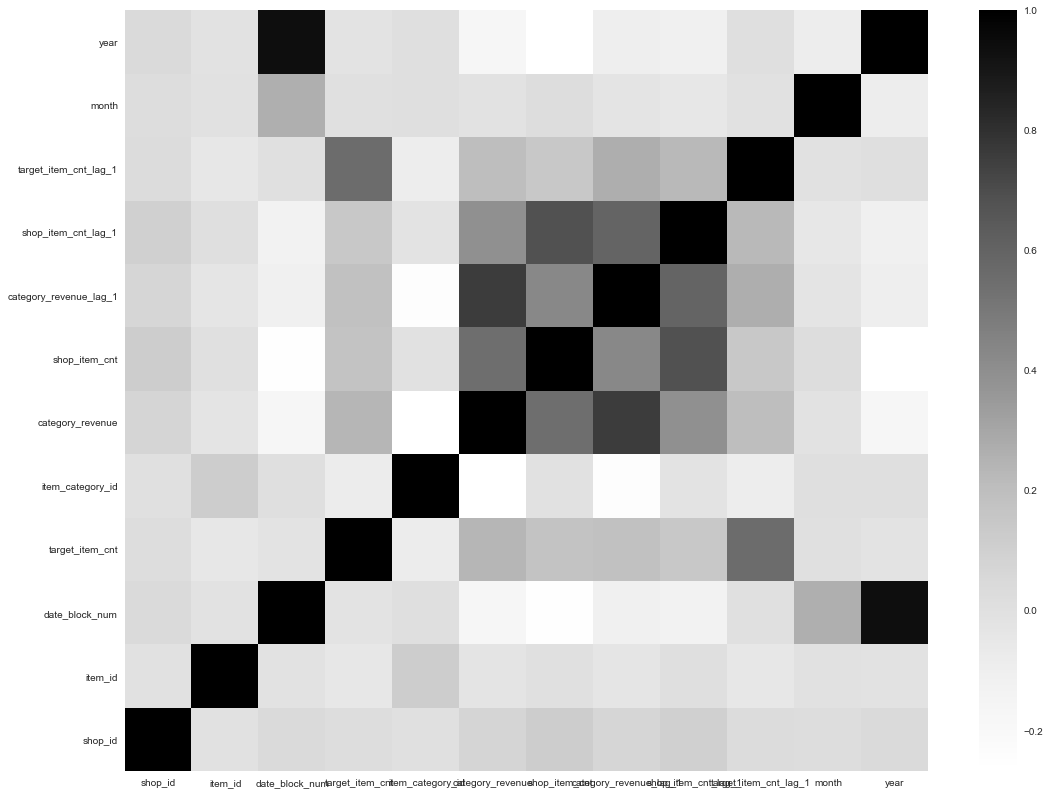

In [156]:
fig = plt.figure(figsize=(18, 14))
corr = all_data.corr()
c = plt.pcolor(corr)
plt.yticks(np.arange(0.5, len(corr.index), 1), corr.index)
plt.xticks(np.arange(0.5, len(corr.columns), 1), corr.columns)
fig.colorbar(c)



In [157]:
to_drop_cols = list(all_data.select_dtypes(include = ['object']).columns) + ['target_item_cnt']

In [158]:
to_drop_cols

['set', 'target_item_cnt']

In [159]:
last_block = 34
X_train_full = all_data.loc[(all_data['date_block_num'] < last_block)].drop(to_drop_cols, axis=1)

In [160]:
y_train_full = all_data.loc[(all_data['date_block_num'] < last_block), 'target_item_cnt'].values


In [161]:
X_test_full = all_data.loc[(all_data['date_block_num'] == last_block)]
X_test_full = pd.merge(X_test_full, sales_test, how='left', on=['shop_id','item_id'])
X_test_full = X_test_full.sort_values(['ID'])
X_test_full = X_test_full.reset_index(drop = True)
ID = X_test_full['ID']
X_test_full = X_test_full.drop(['target_item_cnt']+['ID'], axis = 1)

In [162]:
import random
last_block = 33
sampleSize = 0.2
random.seed(a = 123)
sample= list(all_data.item_id.unique())
sample= list(np.random.choice(sample, size= int(len(sample)*sampleSize), replace=False, p=None))

In [163]:
X_train_1_index = X_train_full.loc[(X_train_full['date_block_num'] <  last_block) & (X_train_full['item_id'].isin(sample))].index
X_val_1_index = X_train_full.loc[(X_train_full['date_block_num'] == last_block) & (X_train_full['item_id'].isin(sample))].index

In [173]:
X_train=X_train_full.iloc[X_train_1_index]
X_val=X_train_full.iloc[X_val_1_index ]

In [174]:
y_train = y_train_full[X_train_1_index]
y_val =  y_train_full[X_val_1_index]

In [175]:
X_train.shape,y_train.shape

((2117455, 11), (2117455,))

In [187]:
preds = []

lgb_params = {
              'feature_fraction': 0.9,
              'metric': 'rmse',
              'nthread':1,
              'min_data_in_leaf': 2**7,
              'bagging_fraction': 0.7,
              'learning_rate': 0.09,
              'objective': 'mse',
              'bagging_seed': 2**7,
              'num_leaves': 2**7,
              'bagging_freq':1,
              'verbose':0
              }

print('Training Model %d: %s'%(len(preds), 'lightgbm'))
start = time.perf_counter()
estimator = lgb.train(lgb_params, lgb.Dataset(X_train, label=y_train), 300)
pred_test = estimator.predict(X_val)
preds.append(pred_test)
pred_train = estimator.predict(X_train)
print('Train RMSE for %s is %f' % ('lightgbm', sqrt(mean_squared_error(y_train, pred_train))))
print('validation  RMSE for %s is %f' % ('lightgbm', sqrt(mean_squared_error(y_val, pred_test))))
run = time.perf_counter() - start
print('{} runs for {:.2f} seconds.'.format('lightgbm', run))
print()


Training Model 0: lightgbm
Train RMSE for lightgbm is 0.822324
validation  RMSE for lightgbm is 0.929103
lightgbm runs for 144.32 seconds.



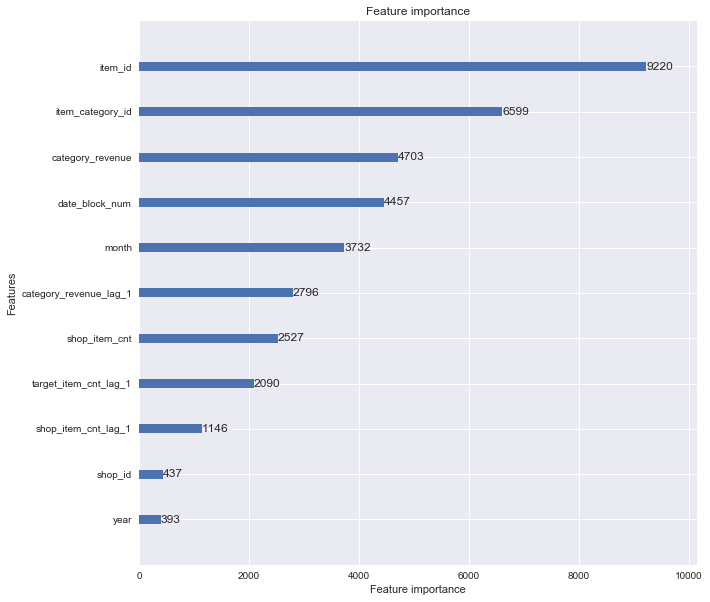

In [177]:
lgb.plot_importance(estimator)

In [178]:
#plot of actual and prediction value

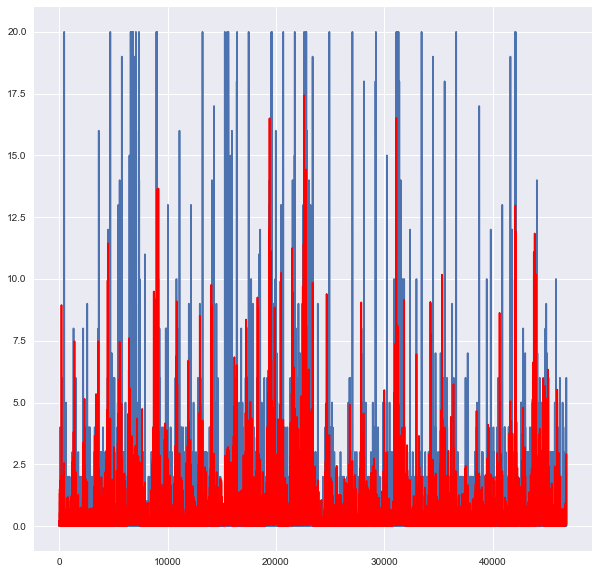

In [179]:
plt.plot(y_val)
plt.plot(pred_test, color='red')
plt.rcParams['figure.figsize'] = [15, 30]
plt.show()

In [180]:
def submission(model, X_test):
   
    # model prediction
    pred = model.predict(X_test)
   

    # create prediction dataframe
    
    output = pd.DataFrame() 
    output['ID'] = ID
    output['item_cnt_month'] = pred
    print(output.head())


    print('result.csv')
    
    output.to_csv(header=True, index=False, path_or_buf = 'submission.csv')
    
    return None

In [181]:
X_test_full.head()

,shop_id,item_id,date_block_num_x,item_category_id,category_revenue,shop_item_cnt,category_revenue_lag_1,shop_item_cnt_lag_1,target_item_cnt_lag_1,month,year,set_x,set_y,date,date_block_num_y,item_price,item_cnt_day
0,5,5037,34,19,0.0,0.0,121220.000000,1054.0,0.0,11,2015,test,test,30.11.2015,34,NaN,NaN
1,5,5320,34,55,0.0,0.0,0.000000,0.0,0.0,11,2015,test,test,30.11.2015,34,NaN,NaN
2,5,5233,34,19,0.0,0.0,121220.000000,1054.0,1.0,11,2015,test,test,30.11.2015,34,NaN,NaN
3,5,5232,34,23,0.0,0.0,98242.398438,1054.0,0.0,11,2015,test,test,30.11.2015,34,NaN,NaN
4,5,5268,34,20,0.0,0.0,0.000000,0.0,0.0,11,2015,test,test,30.11.2015,34,NaN,NaN


In [182]:
X_test_full=X_test_full[['shop_id', 'item_id', 'date_block_num_x', 'item_category_id','category_revenue', 'shop_item_cnt', 'category_revenue_lag_1','shop_item_cnt_lag_1', 'target_item_cnt_lag_1', 'month', 'year']]

In [183]:
submission(estimator, X_test_full)

   ID  item_cnt_month
0   0        0.035509
1   1        0.021956
2   2        0.249217
3   3        0.039990
4   4       -0.068509
result.csv
